# Data processing 
from initial_micro_data_wrangling as netcdf

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import sys
import os
sys.path.append('../..')
from src.data.functions import safe_log, convert_datetime
from src.utils.directories import get_parent_directory

In [2]:
parent_dir = get_parent_directory()
arctic_nc = os.path.join(parent_dir, "data/external/Microstructure/arctic_mmp.nc")
arctic_ds = xr.open_dataset(arctic_nc)

In [3]:
# Convert pressure in dbar to depth (z) using gsw.z_from_p
arctic_ds["z"] = gsw.z_from_p(-arctic_ds["PRESSURE"], arctic_ds["LATITUDE"])

## Convert time


In [4]:
# From cruise report: departed 27 august
# 29 days later is 2015-09-25
# 27th of august to UTC datetime refers to 736203.2053935186.

import datetime

time = arctic_ds.copy()
ds_time = time.TIME.values

# start counting in first year, but need 0th year instead
reference_date = datetime.datetime(1, 1, 1)
days_since_reference = ds_time.min() - 365

reference_date_1 = reference_date + datetime.timedelta(days=days_since_reference)
reference_value_1 = ds_time.min()
reference_date_2 = reference_date_1 + datetime.timedelta(days=ds_time.max()-ds_time.min())
reference_value_2 = ds_time.max()

# Convert the array values to UTC datetimes using linear interpolation
utc_datetimes = np.array([
    reference_date_1 + (value - reference_value_1) * (reference_date_2 - reference_date_1) / (reference_value_2 - reference_value_1)
    for value in ds_time
])

formatted_datetimes = [dt[0].strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in utc_datetimes]
# store formatted array for later
formatted_array = np.array(formatted_datetimes).reshape(time.TIME.shape)

## Bin data

In [5]:
# correlate depth samples to actual depth
# assume that pressure (decibars) of the water correlates to the depth (m)
multiply_factor = arctic_ds.PRESSURE.max().item()/arctic_ds.depth.max().item()
time["depth"] = arctic_ds["depth"]*multiply_factor

In [6]:
bin_ds = arctic_ds
# group data by depth bins
# adjust the labels to reflect the start of each interval
bin_size = np.arange(0, 300.1, 1)
bin_labels = [edge for edge in bin_size[:-1]]
grouped = bin_ds.groupby_bins('depth', bin_size, labels=bin_labels)
# calculate mean of each bin
binned_data = grouped.mean(dim='depth')
binned_data = binned_data.rename({'depth_bins': 'depth'})
binned_data

<xarray.Dataset>
Dimensions:          (depth: 300, length_t: 93, single: 1, length_tm: 9,
                      length_c: 18, length_o: 52, length_i: 3, profiles: 871)
Coordinates:
  * depth            (depth) float64 0.0 1.0 2.0 3.0 ... 296.0 297.0 298.0 299.0
Dimensions without coordinates: length_t, single, length_tm, length_c,
                                length_o, length_i, profiles
Data variables: (12/13)
    title            (depth, length_t, single) |S1 b'M' b'i' b'c' ... b'3' b'1'
    time             (depth, length_tm, single) |S1 b'S' b'e' b'p' ... b'1' b'5'
    chief_scientist  (depth, length_c, single) |S1 b'J' b'e' b'n' ... b'o' b'n'
    data_originator  (depth, length_o, single) |S1 b'M' b'a' b't' ... b't' b't'
    institution      (depth, length_i, single) |S1 b'S' b'I' b'O' ... b'I' b'O'
    LATITUDE         (depth, profiles, single) float64 65.23 65.24 ... 65.73
    ...               ...
    TIME             (depth, profiles, single) float64 7.362e+05 ... 7.362e+05
    EPSILON          (depth, profiles) float64 nan nan nan nan ... nan nan nan
    PRESSURE         (depth, single) float64 0.25 0.5 0.75 ... 74.5 74.75 75.0
    PSAL             (depth, profiles) float64 0.0 nan 0.0 ... 29.64 0.0 29.49
    TEMPERATURE      (depth, profiles) float64 nan nan nan nan ... nan nan nan
    z                (depth, single, profiles) float64 0.2475 0.2475 ... 74.27

In [7]:
# include time in new dataset
binned_data["time"] = (['profiles', 'single'], formatted_array)

Text(0.5, 0, 'Temperature')

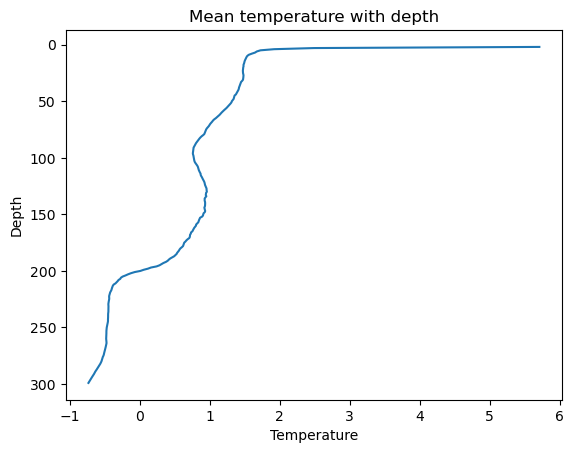

In [8]:
plt.plot(binned_data.TEMPERATURE.mean(dim="profiles"),binned_data.depth)
plt.gca().invert_yaxis()  # invert the y-axis (depth axis)
plt.title("Mean temperature with depth")
plt.ylabel("Depth")
plt.xlabel("Temperature")

In nc dataset, can find time, lat, lon, epsilon, pressure, psal, temperature.
dimensions for this dataset are lengths, profiles and depth

lit review on Arctic and CC and beaufort sea

Understabding Arctic turbulence: beaufort gyre

The Arctic Ocean's beaufort gyre

## Change variable names and save for preprocessing

In [9]:
final_data = binned_data.rename({'PSAL': 'S', 'TEMPERATURE': 'T', 'LONGITUDE': 'longitude', 'LATITUDE':'latitude', "EPSILON":"eps", "PRESSURE":"P"})
final_data.coords["depth"] = final_data.coords["depth"]
final_data = final_data.assign_coords(longitude=final_data['longitude'], latitude=final_data['latitude'])
final_data = final_data.rename_dims({"profiles": "profile"})

In [10]:
final_data = convert_datetime(final_data)
log_eps = np.vectorize(safe_log)(final_data["eps"])
final_data["log_eps"] = xr.DataArray(log_eps, dims=("depth", "profile"))

In [11]:
final_data = final_data.squeeze()

In [12]:
# Construct the file path using the parent directory
file_path = os.path.join(parent_dir, "data", "interim", "arctic_mix.nc")
final_data.to_netcdf(file_path)

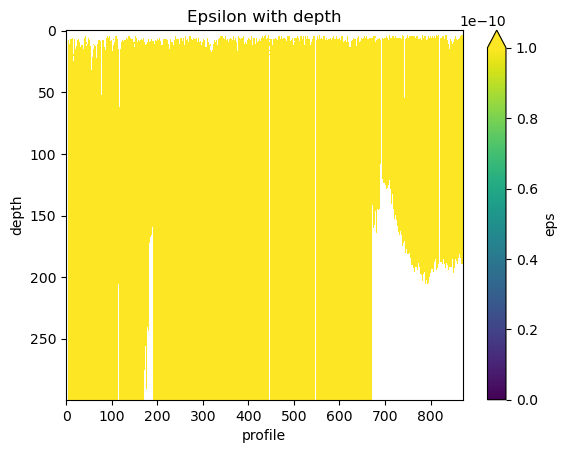

In [18]:
final_data.eps.plot(vmin = 1e-25, vmax = 1e-10)
plt.gca().invert_yaxis()
# Set the axis labels and title
plt.title('Epsilon with depth')
plt.show()

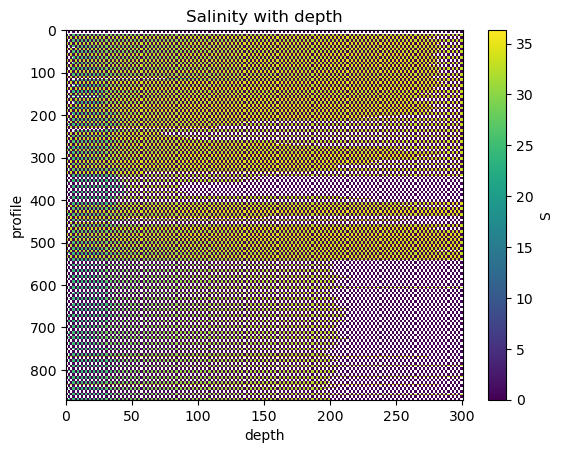

In [122]:
final_data.S.plot()
plt.gca().invert_yaxis()
plt.title('Salinity with depth')
plt.show()